# Configuración del proyecto
Comenzamos importando las librerías.

In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
nltk.download('stopwords')


# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Embedding, SpatialDropout1D, Flatten, Dropout, Conv1D, GlobalMaxPooling1D


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JOHANPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dataset original

In [96]:
df = pd.read_csv('./data/train_data.csv')
df = df.reindex(np.random.permutation(df.index))  
df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
2545,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-03T00:00:00.000Z,"Paid $60 for it on sale during holidays, could...",Great price,Positive
1332,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",Amazon,"Computers,Fire Tablets,Electronics Features,Co...",Electronics,2016-11-28T00:00:00.000Z,I got this because it is almost impossible to ...,bought for my grandson and he loves it.,Positive
3312,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2018-05-24T00:00:00.000Z,Got this for my dad for Christmas. He likes th...,Great step-up from the Echo dot,Positive
2964,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2017-12-05T00:00:00.000Z,"Love this product, super easy to use and able ...",More Amazon Fun,Positive
2289,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-06T00:00:00.000Z,makes things easy to control. connects to othe...,good quality,Positive


In [3]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 100  # Maximum number of words in a sequence
EMBEDDING_DIM = 128  # Dimension of the embedding vector

Leemos el csv con los datos de las reseñas y realizamos una mezcla aleatoria. Es una buena práctica mezclar los datos antes de dividirlos entre train, validation y test data. De esta manera, las clases de sentimiento se distribuyen equitativamente entre el train, validation y test y los conjuntos de prueba.

Solo mantendremos la columna *reseñas* como entrada y la columna *sentiment* como destino.

In [98]:
df = df.rename(columns={'reviews.text': 'reviews',})
df = df[['reviews', 'sentiment']]

df.head()

,reviews,sentiment
2545,"Paid $60 for it on sale during holidays, could...",Positive
1332,I got this because it is almost impossible to ...,Positive
3312,Got this for my dad for Christmas. He likes th...,Positive
2964,"Love this product, super easy to use and able ...",Positive
2289,makes things easy to control. connects to othe...,Positive


In [99]:
df.count()

reviews      4000
sentiment    4000
dtype: int64

In [100]:
df.columns

Index(['reviews', 'sentiment'], dtype='object')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 2545 to 3941
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reviews    4000 non-null   object
 1   sentiment  4000 non-null   object
dtypes: object(2)
memory usage: 93.8+ KB


In [102]:
df.duplicated().sum()

402

In [103]:
df.isnull().sum()

reviews      0
sentiment    0
dtype: int64

In [104]:
df.dtypes

reviews      object
sentiment    object
dtype: object

In [105]:
df.describe()

,reviews,sentiment
count,4000,4000
unique,3598,3
top,Got this for my Daughter-in-Law and she loves ...,Positive
freq,4,3749


## EDA básico del conjunto de datos de entrenamiento 

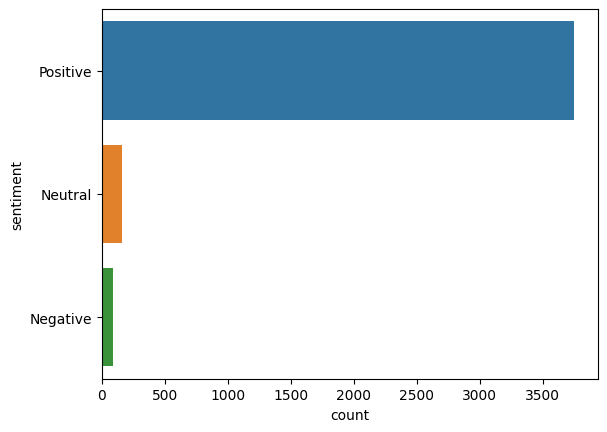

In [106]:
sns.countplot(y=df.sentiment);

<AxesSubplot:xlabel='sentiment', ylabel='count'>

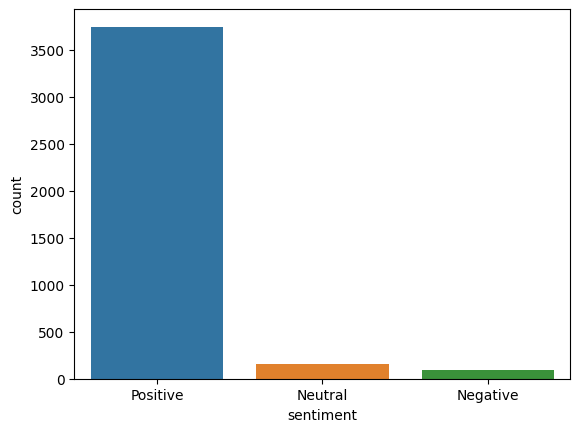

In [107]:
sns.countplot(x='sentiment', data=df)


In [108]:
df.sentiment.value_counts()

Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64

<AxesSubplot:ylabel='sentiment'>

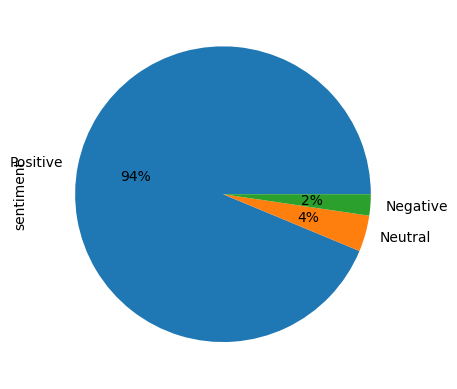

In [109]:
df['sentiment'].value_counts().plot(kind='pie', autopct= '%1.0f%%')

Positive words


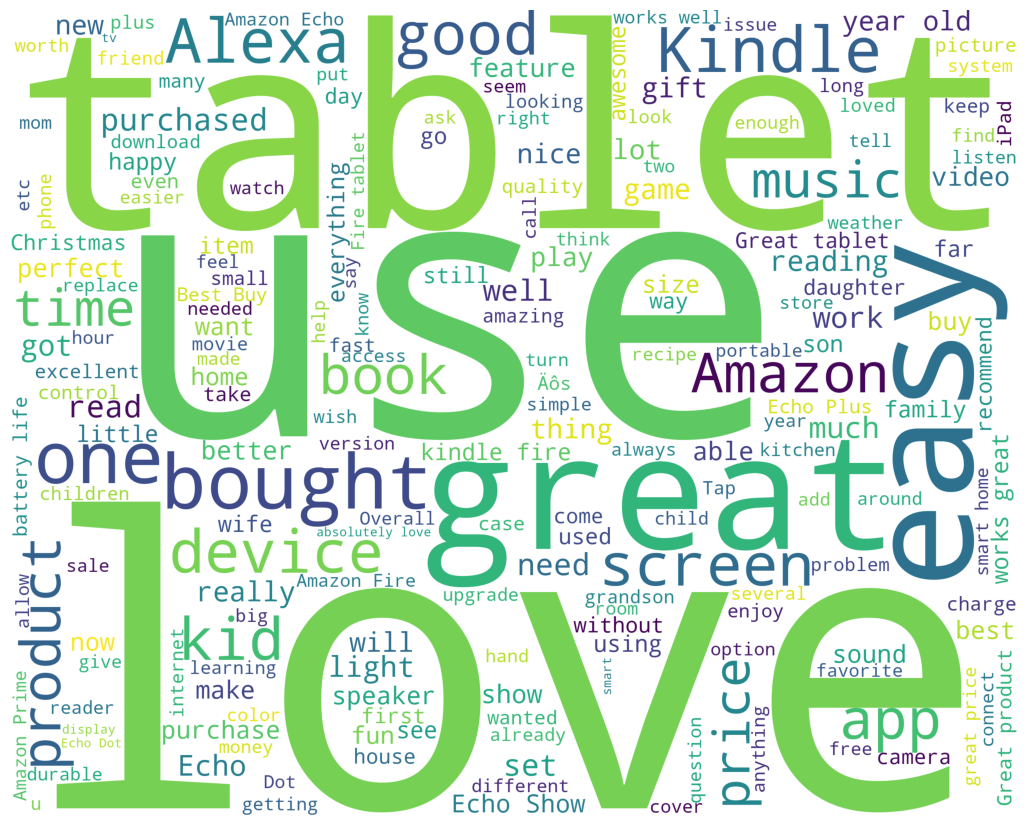

Negative words


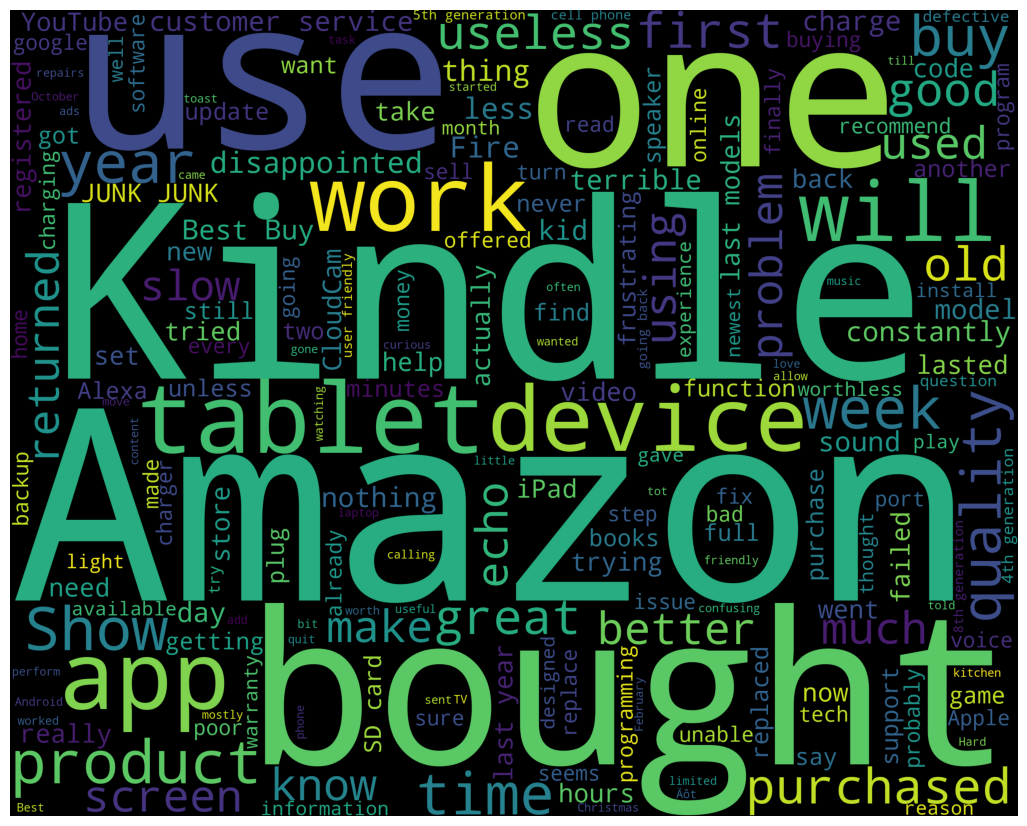

In [110]:
#obtener reviews positivas y negativas
train_pos = df[ df['sentiment'] == 'Positive']
train_pos = train_pos['reviews']
train_neg = df[ df['sentiment'] == 'Negative']
train_neg = train_neg['reviews']

#funcion para generar nube de palabras
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    #cleaning de las reviews
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    #caracteristicas de la nube de palabras
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
#imprimir nube de palabras
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

# Data preparation

### Data cleaning
Lo primero que haremos será eliminar las palabras vacías (stopwords). Estas palabras no tienen ningún valor para predecir el sentimiento. Además, como queremos crear un modelo que también pueda usarse para otros datasets, eliminamos las menciones.


In [111]:
#funcion para eliminar stopwords y menciones
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.reviews = df.reviews.apply(remove_stopwords).apply(remove_mentions)
df.head()

,reviews,sentiment
2545,"Paid $60 sale holidays, ask better product price",Positive
1332,got almost impossible break,Positive
3312,Got dad Christmas. He likes speakers sound bet...,Positive
2964,"Love product, super easy use able lot fun ente...",Positive
2289,makes things easy control. connects products,Positive


### Train, y Test split
Dividimos los datos en dos conjuntos, ya que estamos definiendo al comienzo del notebook los hiperparametros de forma explícita.


In [112]:
X_train, X_test, y_train, y_test = train_test_split(df.reviews, df.sentiment, test_size=0.1, random_state=42)

print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 3600
# Test data samples: 400


### Convertir palabras en números
Para usar el texto como entrada para un modelo, primero necesitamos convertir las palabras de las reseñas en tokes, lo que simplemente significa convertir las palabras en números enteros que hacen referencia a un índice en un diccionario. Aquí sólo mantendremos las palabras más frecuentes en el conjunto de trenes.

Limpiamos el texto aplicando *filtros* y poniendo las palabras en *minúsculas*. Las palabras están separadas por espacios.

In [175]:
# Tokenizar 
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 3600 documents
10000 words in dictionary
Top 5 most common words are: [('it', 1224), ('great', 1156), ('tablet', 940), ('use', 779), ('the', 778)]


Después de haber creado el diccionario podemos convertir el texto a una lista de índices enteros. Esto se hace con el método *text_to_sequences* del Tokenizer.

In [176]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

"Purchased Black FridayPros Great Price (even sale)Very powerful fast quad core processors Amazing soundWell builtCons -Amazon ads, Amazon need subsidize tablet remove adds pay $15.Inability access apps except ones Amazon. There way able accomplish add Google Play storeNet great tablet money" is converted into [15, 23, 21, 59, 493, 813]


In [177]:
X_train_seq = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print('Shape of X_train_seq_trunc:', X_train_seq.shape)

Shape of X_train_seq_trunc: (3600, 100)


Estos números enteros ahora deberían convertirse en características codificadas en caliente (one-hot-encoding).

In [178]:
#funcion one hot encoding
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))


"[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  15  23  21  59 493 813]" is converted into [1. 0. 0. ... 0. 0. 0.]
For this example we have 7.0 features with a value of 1.


In [179]:
np.set_printoptions(threshold=np.inf)

# Imprimir la matriz X_train_oh[5] sin puntos suspensivos
print(X_train_oh[5])

# Restaurar la configuración original de impresión de numpy
np.set_printoptions(threshold=1000)  # Opcional: restaurar el valor original

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

### Converting the target classes to numbers
We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the *to_categorical* method in keras

In [180]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"2" is converted into 2
"2" is converted into [0. 0. 1.]


### Splitting of a validation set
Now that our data is ready, we split of a validation set. This validation set will be used to evaluate the model performance when we tune the parameters of the model. 

In [186]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

X_valid = pad_sequences(X_valid, maxlen=MAX_LEN)
X_train_rest = pad_sequences(X_train_rest, maxlen=MAX_LEN)


print('Shape of validation set:',X_valid.shape)

Shape of validation set: (360, 100)


# Deep learning

### Baseline model
We start with a model with 2 densely connected layers of 64 hidden elements. The *input_shape* for the first layer is equal to the number of words we allowed in the dictionary and for which we created one-hot-encoded features.

As we need to predict 3 different sentiment classes, the last layer has 3 hidden elements. The *softmax* activation function makes sure the three probabilities sum up to 1.

In the first layer we need to estimate 640064 weights. This is determined by (nb inputs * nb hidden elements) + nb bias terms, or (10000 x 64) + 64 = 640064<br>
In the second layer we estimate (64 x 64) + 64 = 4160 weights<br>
In the last layer we estimate (64 x 3) + 3 = 195 weights<br>

In [183]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                640064    
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dense_46 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


## funciones de entrenamiento  y evaluación

Because this project is a multi-class, single-label prediction, we use *categorical_crossentropy* as the loss function and *softmax* as the final activation function. We fit the model on the remaining train data and validate on the validation set. We run for a predetermined number of epochs and will see when the model starts to overfit.

In [121]:
#Función de entrenamient
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy']
                  , 
                  )
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [122]:
#History of the base model
base_history = deep_model(base_model)

To evaluate the model performance, we will look at the training and validation loss and accuracy.

In [123]:
#función para evaluar metricas
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

We can see here that the validation loss starts to increase as from epoch 4. The training loss continues to lower, which is normal as the model is trained to fit the train data as good as possible.

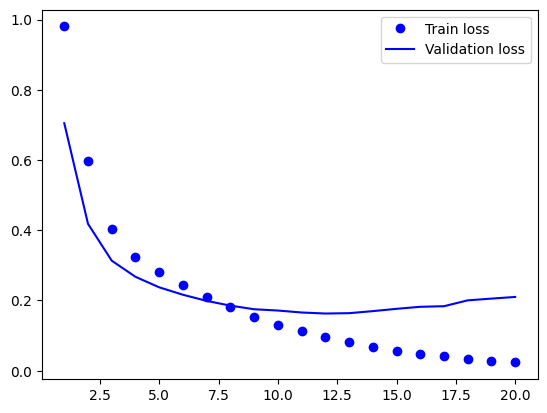

In [124]:
eval_metric(base_history, 'loss')

Just as with the validation loss, the validation accuracy peaks at an early epoch. After that, it goes down slightly. So to conclude, we can say that the model starts overfitting as from epoch 4. 

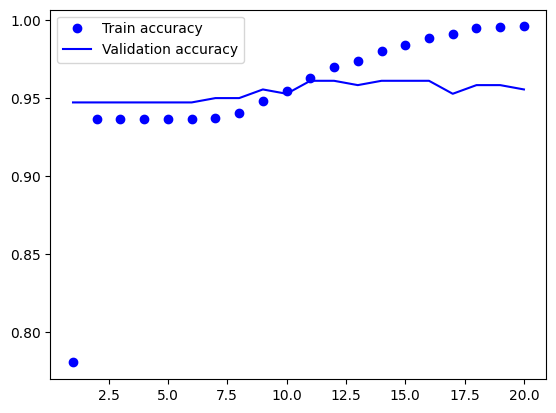

In [125]:
eval_metric(base_history, 'accuracy')


### Handling overfitting
Now, we can try to do something about the overfitting. There are different options to do that.
* Option 1: reduce the network's size by removing layers or reducing the number of hidden elements in the layers
* Option 2: add regularization, which comes down to adding a cost to the loss function for large weights
* Option 3: adding dropout layers, which will randomly remove certain features by setting them to zero

#### Reducing the network's size
We reduce the network's size by removing one layer and lowering the number of hidden elements in the remaining layer to 32.

In [126]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_25"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 32)                320032    
                                                                 
 dense_29 (Dense)            (None, 3)                 99        
                                                                 
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [127]:
reduced_history = deep_model(reduced_model)

In [128]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

We can see that it takes more epochs before the reduced model starts overfitting (around epoch 10). Moreover, the loss increases much slower after that epoch compared to the baseline model.

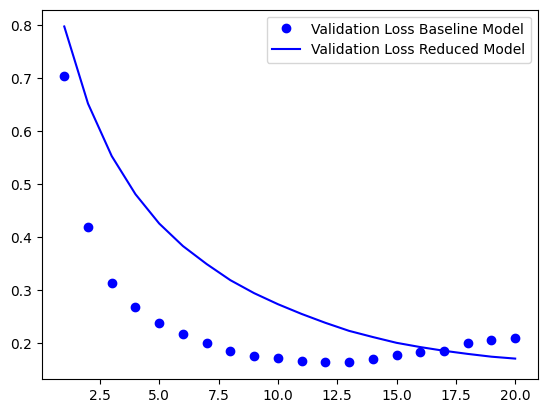

In [129]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

#### Adding regularization
To address overfitting, we can also add regularization to the model. Let's try with L2 regularization.

In [130]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                640064    
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [131]:
reg_history = deep_model(reg_model)

For the regularized model we notice that it starts overfitting earlier than the baseline model. However, the loss increases much slower afterwards.

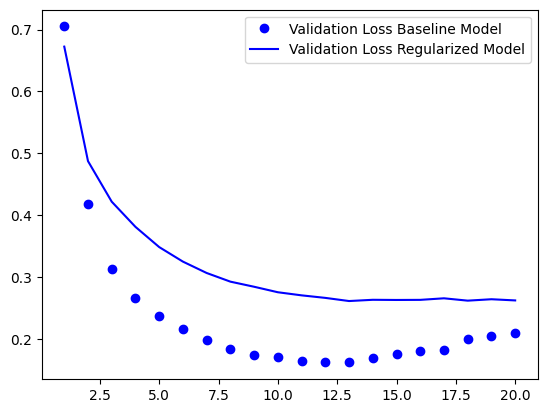

In [132]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

#### Adding dropout layers
The last option we'll try is to add dropout layers.

In [133]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [134]:
drop_history = deep_model(drop_model)

The model with dropout layers starts overfitting a bit later than the baseline model. The loss also increases slower than the baseline model.

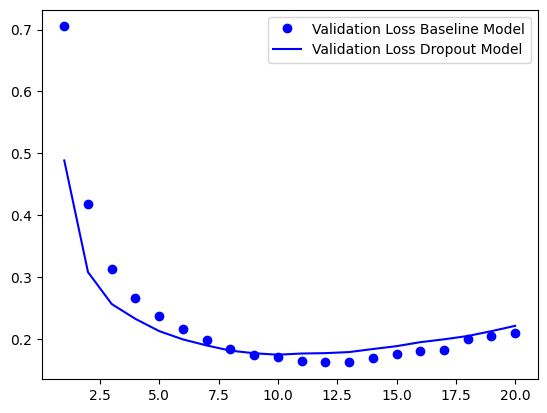

In [135]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

### Training on the full train data and evaluation on test data
At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [136]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [137]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

13/13 [==============================] - 0s 3ms/step - loss: 0.2441 - accuracy: 0.9450
/n
Test accuracy of baseline model: 94.50%


In [138]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

13/13 [==============================] - 0s 3ms/step - loss: 0.1991 - accuracy: 0.9400
/n
Test accuracy of reduced model: 94.00%


In [139]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

13/13 [==============================] - 0s 5ms/step - loss: 0.2676 - accuracy: 0.9425
/n
Test accuracy of regularized model: 94.25%


In [140]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

13/13 [==============================] - 0s 3ms/step - loss: 0.2586 - accuracy: 0.9375
/n
Test accuracy of dropout model: 93.75%


# Long Short Term Memory (LSTM)

Epoch 1/5
7/7 [==============================] - 6s 474ms/step - loss: 1.0459 - accuracy: 0.8034 - val_loss: 0.9198 - val_accuracy: 0.9139
Epoch 2/5
7/7 [==============================] - 3s 388ms/step - loss: 0.6788 - accuracy: 0.9395 - val_loss: 0.3545 - val_accuracy: 0.9139
Epoch 3/5
7/7 [==============================] - 3s 428ms/step - loss: 0.2878 - accuracy: 0.9395 - val_loss: 0.4061 - val_accuracy: 0.9139
Epoch 4/5
7/7 [==============================] - 3s 460ms/step - loss: 0.2803 - accuracy: 0.9395 - val_loss: 0.3530 - val_accuracy: 0.9139
Epoch 5/5
13/13 [==============================] - 0s 22ms/step - loss: 0.2688 - accuracy: 0.9400

Test Accuracy: 0.94


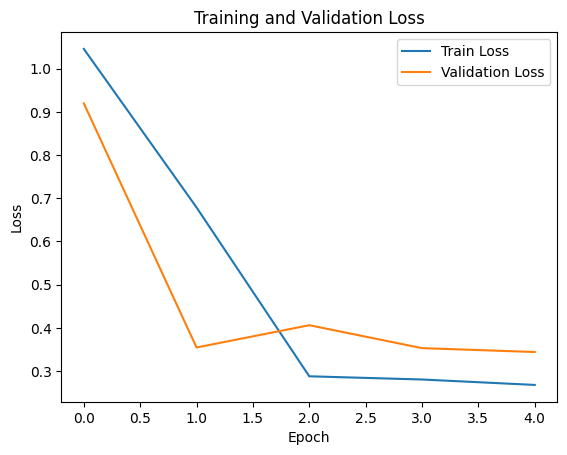

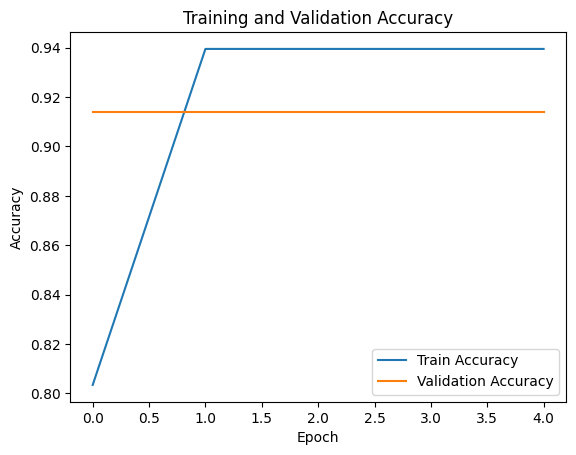

In [245]:


le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df['reviews'], df['sentiment'], test_size=0.1, random_state=37)

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Tokenizar y secuenciar las reseñas
NB_WORDS = 10000  # Número máximo de palabras en el vocabulario
max_len = 100  # Longitud máxima de las secuencias

tokenizer = Tokenizer(num_words=NB_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Convertir etiquetas a codificación one-hot
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test) 

# Pad para que todas las secuencias tengan la misma longitud
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, )
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

# Construir el modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=NB_WORDS, output_dim=128, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
NB_START_EPOCHS = 20  # Número de épocas con las que generalmente empezamos a entrenar
BATCH_SIZE = 512  # Tamaño de los lotes utilizados en el descenso de gradiente de mini-lote

history = model.fit(X_train_padded, y_train, epochs=5, batch_size=BATCH_SIZE, validation_split=0.1)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'\nTest Accuracy: {accuracy:.2f}')

# Mostrar las funciones de pérdida y métricas de rendimiento durante el entrenamiento
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Mostrar la función de pérdida
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Mostrar la métrica de rendimiento (exactitud en este caso)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)


### Función para obtener las métricas de rendimiento

In [142]:

def evaluate_model(y_true, y_pred):
    # Calcular accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")

    # Calcular precision
    precision = precision_score(y_true, y_pred)
    print(f"Precision: {precision}")

    # Calcular sensibilidad (recall)
    sensitivity = recall_score(y_true, y_pred)
    print(f"Sensitivity (Recall): {sensitivity}")

    # Calcular especificidad
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    print(f"Specificity: {specificity}")

    # Calcular F1-score
    f1 = f1_score(y_true, y_pred)
    print(f"F1-Score: {f1}")

    # Devolver las métricas como un diccionario
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Sensitivity (Recall)": sensitivity,
        "Specificity": specificity,
        "F1-Score": f1
    }

# Supongamos que tienes tus datos de prueba y las predicciones del modelo
y_true = [0, 1, 1, 0, 1, 0, 1, 0, 0, 1]  # Etiquetas verdaderas
y_pred = [0, 1, 1, 1, 1, 0, 1, 0, 1, 1]  # Predicciones del modelo

# Calcular métricas
metrics = evaluate_model(y_true, y_pred)


Accuracy: 0.8
Precision: 0.7142857142857143
Sensitivity (Recall): 1.0
Specificity: 0.6
F1-Score: 0.8333333333333333



### Funcion para obtener las matrices de confusión


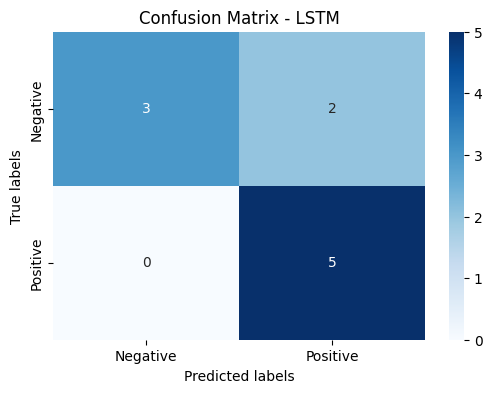

In [143]:
def showConfusionMatrix(name_alg, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    # Mostrar la matriz de confusión utilizando un mapa de calor
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix' + ' - ' + name_alg) # Nombre del algoritmo
    plt.show()


showConfusionMatrix('LSTM', y_true, y_pred)

In [144]:
# Definir la arquitectura del modelo
model2 = Sequential()

# Capa de incrustación (Embedding)
model.add(Embedding(input_dim=10000, output_dim=32, input_length=100))

# Capa LSTM
model.add(LSTM(64))

# Capa densa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 100, 32)           320000    
                                                                 
 lstm_22 (LSTM)              (None, 64)                24832     
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
 embedding_23 (Embedding)    (None, 1, 32)             320000    
                                                                 
 lstm_23 (LSTM)              (None, 64)                24832     
                                                                 
 dense_37 (Dense)            (None, 1)                 65        
                                                                 
Total params: 689,794
Trainable params: 689,794
Non-t

In [254]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(2000, embed_dim,input_length = 100))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_70 (Embedding)    (None, 100, 128)          256000    
                                                                 
 spatial_dropout1d_33 (Spati  (None, 100, 128)         0         
 alDropout1D)                                                    
                                                                 
 lstm_70 (LSTM)              (None, 196)               254800    
                                                                 
 dense_85 (Dense)            (None, 3)                 591       
                                                                 
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


# CONVOLUTIONAL NEURAL NETWORKS CNN

In [18]:
# Definir constantes
NB_WORDS = 10000  # Número máximo de palabras a considerar
EMBEDDING_DIM = 100  # Dimensión de los vectores de embedding
MAX_LEN = 100  # Longitud máxima de las secuencias de palabras
VAL_SIZE = 0.2  # Proporción del conjunto de datos para usar como conjunto de validación
NB_START_EPOCHS = 10  # Número de épocas para entrenar
BATCH_SIZE = 32  # Tamaño del lote durante el entrenamiento

# Cargar el conjunto de datos
df = pd.read_csv('./data/train_data.csv')
df = df.reindex(np.random.permutation(df.index))

# Renombrar la columna de texto de las revisiones
df = df.rename(columns={'reviews.text': 'reviews'})

# Seleccionar columnas relevantes
df = df[['reviews', 'sentiment']]

df = df.dropna(subset=['sentiment'])
df['sentiment'] = le.fit_transform(df['sentiment'])

# Dividir el conjunto de datos en conjuntos de entrenamiento y validación
train_texts, val_texts, train_labels, val_labels = train_test_split(df['reviews'], df['sentiment'], test_size=VAL_SIZE, random_state=42)

# Tokenizar texto y convertirlo a secuencias numéricas
tokenizer = Tokenizer(num_words=NB_WORDS)
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

# Padding para que todas las secuencias tengan la misma longitud
train_data = pad_sequences(train_sequences, maxlen=MAX_LEN)
val_data = pad_sequences(val_sequences, maxlen=MAX_LEN)

# One Hot Encoding para las etiquetas
train_labels_oh = to_categorical(train_labels, num_classes=3)
val_labels_oh = to_categorical(val_labels, num_classes=3)

# Construir el modelo CNN
model = Sequential([
    Embedding(NB_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 clases de sentimiento
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_data, train_labels_oh, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_labels_oh))

# Predecir clases para los datos de validación
val_predictions = model.predict(val_data)

# Obtener las clases predichas
predicted_classes = np.argmax(val_predictions, axis=1)

Epoch 1/10
100/100 [==============================] - 5s 43ms/step - loss: 0.3459 - accuracy: 0.9341 - val_loss: 0.2895 - val_accuracy: 0.9300
Epoch 2/10
100/100 [==============================] - 4s 40ms/step - loss: 0.2320 - accuracy: 0.9391 - val_loss: 0.2421 - val_accuracy: 0.9300
Epoch 3/10
100/100 [==============================] - 4s 36ms/step - loss: 0.1545 - accuracy: 0.9450 - val_loss: 0.2341 - val_accuracy: 0.9362
Epoch 4/10
100/100 [==============================] - 4s 39ms/step - loss: 0.0818 - accuracy: 0.9716 - val_loss: 0.3099 - val_accuracy: 0.9312
Epoch 5/10
100/100 [==============================] - 4s 39ms/step - loss: 0.0410 - accuracy: 0.9853 - val_loss: 0.3708 - val_accuracy: 0.9312
Epoch 6/10
100/100 [==============================] - 5s 45ms/step - loss: 0.0201 - accuracy: 0.9966 - val_loss: 0.4224 - val_accuracy: 0.9287
Epoch 7/10
100/100 [==============================] - 5s 53ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.4612 - val_accuracy: 0.9262

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calcular métricas
accuracy = accuracy_score(val_labels, predicted_classes)
precision = precision_score(val_labels, predicted_classes, average='weighted')
recall = recall_score(val_labels, predicted_classes, average='weighted')
f1 = f1_score(val_labels, predicted_classes, average='weighted')
conf_matrix = confusion_matrix(val_labels, predicted_classes)

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.93125
Precision: 0.9249446741245135
Recall: 0.93125
F1 Score: 0.9203202281694335
Confusion Matrix:
 [[  5   6  12]
 [  0   7  26]
 [  0  11 733]]


# RECURRENT NEURAL NETWORKS (RNN)

In [25]:
# Construir el modelo RNN
model_rnn = Sequential([
    Embedding(NB_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 clases de sentimiento
])

# Compilar el modelo RNN
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo RNN
history_rnn = model_rnn.fit(train_data, train_labels_oh, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_labels_oh))

# Predecir clases para los datos de validación utilizando el modelo RNN
val_predictions_rnn = model_rnn.predict(val_data)

# Obtener las clases predichas
predicted_classes_rnn = np.argmax(val_predictions_rnn, axis=1)

Epoch 1/10
100/100 [==============================] - 18s 155ms/step - loss: 6752271872.0000 - accuracy: 0.9337 - val_loss: 0.2925 - val_accuracy: 0.9300
Epoch 2/10
100/100 [==============================] - 16s 156ms/step - loss: 0.2413 - accuracy: 0.9391 - val_loss: 0.2731 - val_accuracy: 0.9300
Epoch 3/10
100/100 [==============================] - 19s 194ms/step - loss: 0.2117 - accuracy: 0.9391 - val_loss: 1.9570 - val_accuracy: 0.9300
Epoch 4/10
100/100 [==============================] - 22s 224ms/step - loss: 19.9681 - accuracy: 0.9391 - val_loss: 0.2719 - val_accuracy: 0.9300
Epoch 5/10
100/100 [==============================] - 15s 154ms/step - loss: 54.7692 - accuracy: 0.9388 - val_loss: 0.2758 - val_accuracy: 0.9300
Epoch 6/10
100/100 [==============================] - 16s 161ms/step - loss: 0.1796 - accuracy: 0.9391 - val_loss: 0.2863 - val_accuracy: 0.9300
Epoch 7/10
100/100 [==============================] - 15s 151ms/step - loss: 0.9667 - accuracy: 0.9384 - val_loss: 0.28

In [27]:
# Calcular métricas
accuracy_rnn = accuracy_score(val_labels, predicted_classes_rnn)
precision_rnn = precision_score(val_labels, predicted_classes_rnn, average='weighted')
recall_rnn = recall_score(val_labels, predicted_classes_rnn, average='weighted')
f1_rnn = f1_score(val_labels, predicted_classes_rnn, average='weighted')
conf_matrix_rnn = confusion_matrix(val_labels, predicted_classes_rnn)

# Mostrar las métricas
print("Accuracy (RNN):", accuracy_rnn)
print("Precision (RNN):", precision_rnn)
print("Recall (RNN):", recall_rnn)
print("F1 Score (RNN):", f1_rnn)
print("Confusion Matrix (RNN):\n", conf_matrix_rnn)


Accuracy (RNN): 0.9225
Precision (RNN): 0.8802679175118324
Recall (RNN): 0.9225
F1 Score (RNN): 0.9002348722986249
Confusion Matrix (RNN):
 [[  0   5  18]
 [  0   3  30]
 [  0   9 735]]


c:\Users\JOHANPC\miniconda3\envs\producto\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# GATED RECURRENT UNIT

In [28]:
from keras.layers import GRU

# Construir el modelo con GRU
model_gru = Sequential([
    Embedding(NB_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    GRU(128, activation='relu', dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 clases de sentimiento
])

# Compilar el modelo GRU
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo GRU
history_gru = model_gru.fit(train_data, train_labels_oh, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_labels_oh))

# Predecir clases para los datos de validación utilizando el modelo GRU
val_predictions_gru = model_gru.predict(val_data)

# Obtener las clases predichas
predicted_classes_gru = np.argmax(val_predictions_gru, axis=1)


Epoch 1/10
100/100 [==============================] - 16s 133ms/step - loss: 0.3789 - accuracy: 0.9366 - val_loss: 0.2792 - val_accuracy: 0.9300
Epoch 2/10
100/100 [==============================] - 12s 121ms/step - loss: 0.2130 - accuracy: 0.9391 - val_loss: 0.2673 - val_accuracy: 0.9300
Epoch 3/10
100/100 [==============================] - 15s 148ms/step - loss: 0.1643 - accuracy: 0.9391 - val_loss: 0.2695 - val_accuracy: 0.9300
Epoch 4/10
100/100 [==============================] - 12s 122ms/step - loss: 0.1226 - accuracy: 0.9406 - val_loss: 0.3223 - val_accuracy: 0.9287
Epoch 5/10
100/100 [==============================] - 13s 133ms/step - loss: 0.1012 - accuracy: 0.9547 - val_loss: 0.3632 - val_accuracy: 0.9300
Epoch 6/10
100/100 [==============================] - 13s 132ms/step - loss: 0.0875 - accuracy: 0.9616 - val_loss: 0.4707 - val_accuracy: 0.9137
Epoch 7/10
100/100 [==============================] - 14s 140ms/step - loss: 0.0592 - accuracy: 0.9762 - val_loss: 0.5438 - val_ac

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calcular métricas
accuracy_gru = accuracy_score(val_labels, predicted_classes_gru)
precision_gru = precision_score(val_labels, predicted_classes_gru, average='weighted')
recall_gru = recall_score(val_labels, predicted_classes_gru, average='weighted')
f1_gru = f1_score(val_labels, predicted_classes_gru, average='weighted')
conf_matrix_gru = confusion_matrix(val_labels, predicted_classes_gru)

# Mostrar las métricas
print("Accuracy (GRU):", accuracy_gru)
print("Precision (GRU):", precision_gru)
print("Recall (GRU):", recall_gru)
print("F1 Score (GRU):", f1_gru)
print("Confusion Matrix (GRU):\n", conf_matrix_gru)


Accuracy (GRU): 0.91375
Precision (GRU): 0.9032468624611579
Recall (GRU): 0.91375
F1 Score (GRU): 0.906211273856188
Confusion Matrix (GRU):
 [[  5   2  16]
 [  1   6  26]
 [  3  21 720]]
